# Метрики

## Imports

In [ ]:
!pip install rectools

In [ ]:
url = 'https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_original.zip'

In [ ]:
req = requests.get(url, stream=True)

with open('kion.zip', 'wb') as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

In [ ]:
import zipfile as zf

files = zf.ZipFile('kion.zip','r')
files.extractall()
files.close()

In [ ]:
import pandas as pd
import numpy as np
import numba as nb

from tqdm.auto import tqdm
from rectools import Columns

In [ ]:
np.random.seed(23)

## Read data

In [6]:
interactions = pd.read_csv('/content/interactions.csv')

interactions.rename(
    columns={
        'track_id': Columns.Item,
        'last_watch_dt': Columns.Datetime,
        'total_dur': Columns.Weight
    }, 
    inplace=True) 

interactions[Columns.Datetime] = pd.to_datetime(interactions[Columns.Datetime])

In [ ]:
users = pd.read_csv('data_original/users.csv')
items = pd.read_csv('data_original/items.csv')

In [ ]:
def headtail(df):
    return pd.concat([df.head(), df.tail()])

headtail(interactions)

In [ ]:
interactions.info(memory_usage='deep')

Выделим небольшой кусок из данных, чтобы не слишком страдать

In [ ]:
sample_users = [57607, 403227, 70720]
df = interactions[interactions[Columns.User].isin(sample_users)].reset_index(drop=True)
del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']
df

,user_id,item_id
0,70720,4880
1,57607,4151
2,57607,10440
3,70720,4881
4,403227,6353
5,403227,1736
6,70720,6327
7,57607,13865
8,403227,5336
9,403227,181


In [ ]:
print('Users', df[Columns.User].unique())
sample_items = df[Columns.Item].unique()
print('Items', sample_items)

## Regression

В регрессией все относительно просто. По (user, item) мы знаем таргет (рейтинг чаще всего) и по такой же паре предсказываем его

In [ ]:
df['target'] = np.random.choice([3, 4, 5], df.shape[0])
df['predict'] = np.random.rand(df.shape[0]) * 3 + 2
df

Общая оценка

In [ ]:
mae = (df['target'] - df['predict']).abs().mean()
print(mae)

Оценка по пользователю с последюущим усреднением

In [ ]:
df['diff'] = (df['target'] - df['predict']).abs()
average_mae = df.groupby(Columns.User)['diff'].mean()
print(average_mae.mean())
average_mae

Видно, что в данном случае метрики близки к друг другу, но это не всегда так

In [ ]:
del df['target'], df['predict'], df['diff']

## Classification

Сгенерируем случайные рекомендации.

In [ ]:
top_k = 5
recs = np.array([
    np.random.choice(sample_items, top_k, replace=False),
    np.random.choice(sample_items, top_k, replace=False),
    np.random.choice(sample_items, top_k, replace=False),
])
recs

Преобразуем в длинный датафрейм

In [ ]:
df_recs = pd.DataFrame({
    Columns.User: np.repeat(sample_users, top_k),
    Columns.Item: recs.ravel()
})
df_recs

In [ ]:
df_recs[Columns.Rank] = df_recs.groupby(Columns.User).cumcount() + 1
headtail(df_recs)

Ключевой момент. Именно ради него преобразовывали данные и именно это позволяет считать метрики быстрее.

In [ ]:
df_recs = df.merge(df_recs, how='left', left_on=Columns.UserItem, right_on=Columns.UserItem)
df_recs = df_recs.sort_values(by=[Columns.User, Columns.Rank])
df_recs

### Precision@K

In [ ]:
df_recs[f'TP@5'] = df_recs['rank'] < 6
df_recs

In [ ]:
df_recs[df_recs[Columns.Rank].notnull()]

Посчитаем вручную (1/5 + 1/5 + 3/5) / 3

In [ ]:
df_recs['TP@5/5'] = df_recs['TP@5'] / top_k 

p5 = df_recs.groupby(Columns.User)['TP@5/5'].sum().mean()

print(f'Precision@5 = {p5}')

In [ ]:
df_recs

Используем тот факт, что мы знаем количество пользователей, а значит groupby не нужен

In [ ]:
p5 = df_recs['TP@5/5'].sum() / len(sample_users)
print(f'Precision@5 = {p5}')

### Recall@K

In [ ]:
df_recs['actual'] = df_recs.groupby(Columns.User)[Columns.Item].transform('count')
df_recs

In [ ]:
df_recs['TP@5/actual'] = df_recs['TP@5'] / df_recs['actual']
df_recs

In [ ]:
(1/3 + 1/3 + 3/4) / 3

In [ ]:
r5 = df_recs.groupby(Columns.User)['TP@5/actual'].sum().mean()
print(f'Recall@5 = {r5}')

In [ ]:
r5 = df_recs['TP@5/actual'].sum() / len(sample_users)
print(f'Recall@5 = {r5}')

## Ranking

### MAP@K

In [ ]:
df_recs

In [ ]:
df_recs['cumTP@5'] = df_recs.groupby(Columns.User)['TP@5'].cumsum()
df_recs

In [ ]:
df_recs['Prec@5'] = df_recs['cumTP@5'] / df_recs[Columns.Rank]
df_recs

In [ ]:
df_recs['Prec@5/actual'] = df_recs['Prec@5'] / df_recs['actual']
df_recs

In [ ]:
ap = df_recs.groupby(Columns.User)['Prec@5/actual'].sum()
print(ap.mean())
ap

## Naive vs Numba vs Pandas

In [7]:
df

NameError: ignored

In [8]:
target = df.values
target

NameError: ignored

In [ ]:
target[target[:, 0] == 513902][:, 1]

In [ ]:
recs

In [9]:
def precision_naive(target, users, recs, k):
    precision = []
    for i, user in enumerate(users):
        p = 0
        user_target = target[target[:, 0] == user][:, 1]
        for rec in recs[i]:
            if rec in user_target:
                p += 1
        precision.append(p / k)
    return sum(precision) / len(users)

In [ ]:
precision_naive(target, sample_users, recs, 5)

In [ ]:
@nb.njit(cache=True, parallel=True)
def precision_numba(target, users, recs, k):
    precision = np.zeros(len(users))
    for i in nb.prange(len(users)):
        user = users[i]
        p = 0
        user_target = target[target[:, 0] == user][:, 1]
        for rec in recs[i]:
            if rec in user_target:
                p += 1
        precision[i] = p / k
    return precision.mean()

In [ ]:
precision_numba(target, np.array(sample_users), recs, 5)

In [ ]:
precision_numba(target, np.array(sample_users), recs, 5)

In [ ]:
def precision_pandas(df, users, recs, k):
    df_recs = pd.DataFrame({
        Columns.User: np.repeat(users, k),
        Columns.Item: recs.ravel()
    })
    df_recs[Columns.Rank] = df_recs.groupby(Columns.User).cumcount() + 1
    df_recs = df.merge(df_recs, how='left', left_on=Columns.UserItem, right_on=Columns.UserItem)
    tp_k = f'TP@{k}'
    df_recs[tp_k] = df_recs[Columns.Rank] < (k + 1)
    p = df_recs[tp_k].sum() / k / len(users)
    return p

In [ ]:
precision_pandas(df, sample_users, recs, 5)

Посмотрим через `timeit`

In [ ]:
%timeit precision_naive(target, sample_users, recs, 5)

In [ ]:
%timeit precision_numba(target, sample_users, recs, 5)

In [ ]:
%timeit precision_pandas(df, sample_users, recs, 5)

In [ ]:
def generate_subsample(users_count, top_k):
    users = np.random.choice(interactions[Columns.User].unique(), users_count, replace=False)
    df = interactions[interactions[Columns.User].isin(users)].reset_index(drop=True)
    del df[Columns.Datetime], df[Columns.Weight], df['watched_pct']
    
    recs = np.random.choice(df[Columns.Item], size=(users_count, top_k))
    return df, users, recs

In [ ]:
top_k = 10
df, users, recs = generate_subsample(10000, top_k)
target = df.values

In [ ]:
%timeit precision_naive(target, users, recs, top_k)

In [ ]:
precision_numba(target, users, recs, top_k)

In [ ]:
%timeit precision_numba(target, users, recs, top_k)

In [ ]:
%timeit precision_pandas(df, users, recs, top_k)

## RecTools

Рассмотрим, как использовать библиотеку от МТС для подсчета метрик.

Полный гайд тут - [RecTools/examples/3_metrics.ipynb](https://github.com/MobileTeleSystems/RecTools/blob/main/examples/3_metrics.ipynb)

Вначале вспомним, какие данные есть у нас

In [ ]:
df.shape, users.shape, recs.shape

In [ ]:
from rectools.metrics import Precision, Recall, MAP, calc_metrics

In [ ]:
metrics = {
    "prec@1": Precision(k=1),
    "prec@10": Precision(k=10),
    "recall@10": Recall(k=10),
    "MAP@5": MAP(k=5),
    "MAP@10": MAP(k=10),
}

In [ ]:
catalog = df[Columns.Item].unique()

In [ ]:
df_recs = pd.DataFrame({
    Columns.User: np.repeat(users, top_k),
    Columns.Item: recs.ravel()
})
df_recs[Columns.Rank] = df_recs.groupby(Columns.User).cumcount() + 1

In [ ]:
metric_values = calc_metrics(
    metrics,
    reco=df_recs,
    interactions=df,
)

In [ ]:
metric_values

Как посчитать одну метрику

In [ ]:
metrics['prec@10'].calc(df_recs, df)

In [ ]:
%timeit metrics['prec@10'].calc(df_recs, df)

In [ ]:
metrics['prec@10'].calc_per_user(df_recs, df)

## Homework

### PFound
Исходные данные - Yandex Cup 2022 Analytics
- Ссылка - https://yandex.ru/cup/analytics/analysis/ , пример A. Рассчитать pFound
- Данные - https://yadi.sk/d/guqki4UI4hFlXQ
- Формула
$$pFound@K = \sum_{i=1}^{k} pLook[i]\ pRel[i]$$

$$pLook[1] = 1$$

$$pLook[i] = pLook[i-1]\ (1 - pRel[i-1])\ (1 - pBreak)$$

$$pBreak = 0.15$$

**Задача** - написать функцию, которая принимает на вход dataframe (после join), а на выходе дает средний pFound по всем query.
- Запрещается использовать циклы for для расчет метрики (как полностью, так и ее частей).
- Усложнение, если задача показалась легкой - попробуйте обойтись без groupby (не уверен, что это возможно, но вдруг вы справитесь)

In [ ]:
import requests
from urllib.parse import urlencode

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://yadi.sk/d/guqki4UI4hFlXQ'


final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

download_response = requests.get(download_url)
with open('./data.zip', 'wb') as f:
    f.write(download_response.content)

In [ ]:
# !unzip data.zip
# !unzip hidden_task.zip
# !unzip open_task.zip

Archive:  hidden_task.zip
  inflating: hostid_url.tsv          
  inflating: qid_query.tsv           
  inflating: qid_url_rating.tsv      
Archive:  open_task.zip
   creating: open_task/
  inflating: open_task/qid_query.tsv  
  inflating: open_task/hostid_url.tsv  
  inflating: open_task/qid_url_rating.tsv  


##Pfound

In [ ]:
qid_query.head(3) #  id запроса и текст запроса, разделённые табуляцией;

,qid,query
0,402111,работа фотографом в австралии
1,405851,производительность видеокарт
2,407522,ёлочные игрушки из пластиковых бутылок


In [ ]:
qid_url_rating.head(3) #  id запроса, URL документа, релевантность документа запросу;

,qid,url,rating
0,402111,http://24-job.com/board/job_australia/232-1-2-...,0.07
1,402111,http://24-job.com/board/job_australia/232-1-2-...,0.07
2,402111,http://802351.info/5964-v-avstralii.html,0.00


In [ ]:
hostid_url.head(3) #  id хоста и URL документа.

,hostid,url
0,1,http://09spravki.ru/requisites.php
1,10,http://3pu.info/seo-tools/domains
2,1006,http://www.priroda.su/item/820


In [ ]:
qid_url_rating_hostid.sample(3) 

,qid,url,rating,hostid
583,70357,http://necessary-soft.net/misc/103661-telefonn...,0.14,373
773,99543,http://spb.kp.ru/2007/02/01/doc161469,0.00,521
390,58989,http://www.mp3zzz.ru/song/27511.html,0.00,945


In [ ]:
import pandas as pd

# считываем данные
qid_query = pd.read_csv("qid_query.tsv", sep="\t", names=["qid", "query"])
qid_url_rating = pd.read_csv("qid_url_rating.tsv", sep="\t", names=["qid", "url", "rating"])
hostid_url = pd.read_csv("hostid_url.tsv", sep="\t", names=["hostid", "url"])

# делаем join двух таблиц, чтобы было просто брать url с максимальным рейтингом
qid_url_rating_hostid = pd.merge(qid_url_rating, hostid_url, on="url")


def plook(ind, rels):
    if ind == 0:
        return 1
    return plook(ind-1, rels)*(1-rels[ind-1])*(1-0.15)


def pfound(group):
    max_by_host = group.groupby("hostid")["rating"].max() # максимальный рейтинг хоста
    top10 = max_by_host.sort_values(ascending=False)[:10] # берем топ10 урлов с наивысшим рейтингом
    pfound = 0
    for ind, val in enumerate(top10):
        pfound += val*plook(ind, top10.values)
        print(plook(ind, top10.values))
    return pfound


qid_pfound = qid_url_rating_hostid.groupby('qid').apply(pfound) # группируем по qid и вычисляем pfound
qid_max = qid_pfound.idxmax() # берем qid с максимальным pfound

qid_query[qid_query["qid"] == qid_max]


In [ ]:
avg_pfound_original = qid_pfound.mean()
print(f'Средний pFound по всем query (расчет с сайта): {avg_pfound_original}')

Средний pFound по всем query (расчет с сайта): 0.5822199638393889


In [ ]:
def fast_PFoundK(
    qid_url_rating_hostid,
    K = 10,
    p_break = 0.15
    ):
    """
    Подсчет метрики PFound@K
    """
    # Получаем максимальный рейтинг для кажого url, и потом сортируем
    max_by_host = qid_url_rating_hostid.groupby(['qid', 'hostid'])['rating'].max().reset_index()
    top = max_by_host.sort_values(['qid', 'rating'], ascending=False).groupby(['qid']).head(10)

    top['rank'] = top.groupby('qid').cumcount()  # Задаем порядок для отсортированного рейтинга
     # Ниже идут вспомогательные операции для подсчета метрики
    top['one_minus_rating'] = (1 - top['rating']).shift(1)
    top['p_break'] = 1 - p_break
    top.loc[top['rank'] == 0, ['p_break', 'one_minus_rating']] = 1

    top['temp_with_mult'] = top['one_minus_rating'] * top['p_break']

    top['plook'] = top.groupby('qid')['temp_with_mult'].cumprod()
    top['pfound'] = top['plook'] * top['rating']
    
    pfound_qid = top.groupby('qid')['pfound'].sum() # Подсчет pFound
    return pfound_qid.mean()

In [ ]:
print(fast_PFoundK(qid_url_rating_hostid)) 

0.5822199638393889


##MRR

### MRR
Исходные данные - результат `generate_subsample` 

**Задача** - по аналогии с precision написать три версии функции подсчета Mean Reciprocal Rank (naive, numba, pandas) и протестировать на разных размерах выборки
- Протестируйте для всех комбинаций (users_count, top_k):
  - users_count - [100, 1000, 10000, 100000]
  - top_k - [10, 50, 100]
- Результатом тестирования должен быть график, где будут отражены следующие показатели:
  - Алгоритм - naive, numba, pandas
  - Скорость работы (время)
  - users_count
  - top_k

In [45]:
#  генерация данных
top_k = 10
df, users, recs = generate_subsample(10000, top_k)
target = df.values

In [42]:
def mrr_pandas(df, users, recs, top_k):
    # Формируем датасет
    df_r = pd.DataFrame({
        Columns.User: np.repeat(users, top_k),#повторяем user_id "к раз
        Columns.Item: recs.ravel()#вытягиваем все рекомендации в 1 общий массив
    })
    #составляем ранги
    df_r[Columns.Rank] = df_r.groupby(Columns.User).cumcount() + 1
    #делаем джоин, чтобы понять ранги рекомендаций, которые были предсказаны верно
    df_r = df_r.merge(df, how='right', left_on=Columns.UserItem, right_on=Columns.UserItem)
    # 1/rank(i)
    df_r['revert_rank'] =  1 / df_r[Columns.Rank]
    # заполняем нулями пропуски
    df_r['revert_rank'] = df_r['revert_rank'].fillna(0)
    # считаем итоговую формулу
    mrr = df_r['revert_rank'].sum() / (top_k * len(users))
    return mrr

In [46]:
mrr_pandas(df, users, recs, 10)

0.004555686507936509

In [43]:
def mrr_naive(df, users, recs, k):
    mrp = []
    for i, j in enumerate(users):
        mrp_value = 0
        # находим список item_id у юзера
        user_target = list(df[df[Columns.User] == j][Columns.Item])
        # далее проходим по каждой рекомендации для юзера 
        for rank, rec in enumerate(recs[i]):
            # проверяем, взаимодействовал ли этот пользователь с рекомендацией
            if rec in user_target:
                # если да, то делаем 1/rank и суммируем
                mrp_value += 1 / (rank + 1)
        mrp.append(mrp_value / k)
    
    return sum(mrp) / len(users)

In [47]:
mrr_naive(df, users, recs, 10)

0.004555686507936524

In [44]:
@nb.njit(cache=True, parallel=True)
def mrr_numba(target, users, recs, k):
    mrp = np.zeros(len(users))
    for i in nb.prange(len(users)):
        mrp_value = 0
        # находим список item_id у юзера
        user_target = target[target[:, 0] == users[i]][:, 1]
        # далее проходим по каждой рекомендации для юзера 
        for rank in nb.prange(len(recs[i])):
          # проверяем, взаимодействовал ли этот пользователь с рекомендацией
            if  recs[i][rank] in user_target:
                mrp_value += 1 / (rank + 1)
        mrp[i] = mrp_value / k
    return mrp.mean()

In [48]:
mrr_numba(target, users, recs, 10)

0.004555686507936525

In [49]:
from tqdm import tqdm

In [53]:
users_count = [100, 1000, 10000, 100000]
top_k = [10, 50, 100]
time_pandas = []
time_naive = []
time_numba = []
for user in tqdm(users_count):
  for k in top_k:
    df, users, recs = generate_subsample(user, k)
    target = df.values
    start_time = time.time()
    mrr_pandas(df, users, recs, k)
    time_pandas.append((time.time() - start_time))
    start_time = time.time()
    mrr_naive(df, users, recs, k)
    time_naive.append((time.time() - start_time))
    start_time = time.time()
    mrr_numba(target, users, recs, k)
    time_numba.append((time.time() - start_time))

100%|██████████| 4/4 [07:42<00:00, 115.70s/it]


In [55]:
time_pandas

[0.008422613143920898,
 0.009480714797973633,
 0.010240793228149414,
 0.009877443313598633,
 0.015596389770507812,
 0.029097795486450195,
 0.046714067459106445,
 0.270660400390625,
 0.42557597160339355,
 0.613133430480957,
 2.065725803375244,
 3.9883222579956055]

In [56]:
time_naive

[0.049347639083862305,
 0.05051016807556152,
 0.06595516204833984,
 0.5089960098266602,
 0.5636560916900635,
 0.4723684787750244,
 4.68702244758606,
 5.007227897644043,
 5.193063020706177,
 80.97229027748108,
 81.45811486244202,
 83.26110553741455]

In [54]:
time_numba

[0.0005192756652832031,
 0.0002493858337402344,
 0.0002942085266113281,
 0.008340835571289062,
 0.006719827651977539,
 0.006752490997314453,
 0.6041631698608398,
 0.6019408702850342,
 0.6166503429412842,
 63.18598508834839,
 62.69730997085571,
 62.67359137535095]

In [98]:
time_pandas = np.array(time_pandas).reshape((4, 3))
time_naive = np.array(time_naive).reshape((4,3))
time_numba = np.array(time_numba).reshape((4,3 ))

In [57]:
import matplotlib.pyplot as plt

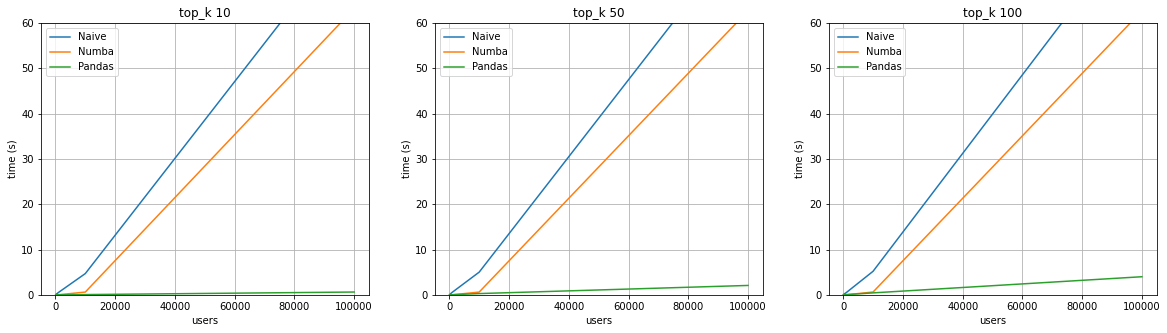

In [101]:
_, ax = plt.subplots(1,3, figsize=(20,5))
for i in range(3):
    ax[i].plot(users_count, time_naive[:,i], label='Naive')
    ax[i].plot(users_count, time_numba[:,i], label='Numba')
    ax[i].plot(users_count, time_pandas[:,i], label='Pandas')
    ax[i].set_title(f'top_k {top_k[i]}')
    ax[i].set_xlabel('users')
    ax[i].set_ylabel('time (s)')
    ax[i].set_ylim(0, 60)
    ax[i].grid()
    ax[i].legend()
plt.show()

Время работы numba зависит от кол-ва ядер процессора, поэтому в коллабе не рекомендуется запускать)